Projekt ten do działania wymaga środowiska Python w wersji 3.7 lub nowszej:

In [10]:
import sys

assert sys.version_info >= (3, 7)

Wymagana jest także biblioteka Scikit-Learn ≥1.0.1:

In [11]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

Jak również TensorFlow ≥ 2.8:

In [12]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

Podobnie jak wcześniej, zdefiniujmy domyślne rozmiary czcionek, aby nasze rysunki wyglądały pięknie:

In [13]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Strojenie hiperparametrów sieci neuronowej

W tej sekcji znów skorzystamy z zestawu danych Fashion MNIST:

In [14]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

4422102/4422102 [==============================] - 1s 0us/step


In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [16]:
if "google.colab" in sys.modules:
    %pip install -q -U keras_tuner

In [17]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

Using TensorFlow backend


In [18]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid))

Trial 5 Complete [00h 00m 18s]
val_accuracy: 0.8393999934196472

Best val_accuracy So Far: 0.8518000245094299
Total elapsed time: 00h 01m 31s


In [19]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [20]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # najlepsze wartości hiperparametrów

{'n_hidden': 7,
 'n_neurons': 100,
 'learning_rate': 0.0012482904754698163,
 'optimizer': 'sgd'}

In [21]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 1 summary
Hyperparameters:
n_hidden: 7
n_neurons: 100
learning_rate: 0.0012482904754698163
optimizer: sgd
Score: 0.8518000245094299


In [22]:
best_trial.metrics.get_last_value("val_accuracy")

0.8518000245094299

In [23]:
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

Epoch 1/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3318 - accuracy: 0.8785
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3229 - accuracy: 0.8810
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3137 - accuracy: 0.8846
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3058 - accuracy: 0.8869
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3005 - accuracy: 0.8876
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2935 - accuracy: 0.8909
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2874 - accuracy: 0.8942
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2822 - accuracy: 0.8947
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2766 - accuracy: 0.8982
Epoch 10/10
313/313 [==============================] - 0s 628us/step - loss: 0.408

W pewnych przypadkach możesz chcieć dostroić hiperparametry wstępnego przetwarzania danych lb argumenty metody `fit()` takie, jak rozmiar wsadu. W tym celu musisz skorzystać z nieco innej techniki: zamiast pisać funkcję `build_model()` , musisz stworzyć podklasę klasy `kt.HyperModel` oraz zdefiniować dwie metody: `build()` oraz `fit()`. Metoda `build()` realizuje dokładnie to samo zadanie, co funkcja `build_model()`. Metoda `fit()` przyjmuje obiekt `HyperParameters()` i skompilowany model jako argumenty, a także wszystkie argumenty ,etody `model.fit()`, po czym trenuje model i zwraca obiekt `History` Jest kwestią zasadniczą, że metoda `fit()` może na podstawie hiperparametrów wyznaczyć sposób wstępnego przetwarzania danych, poprawić rozmiar wsadu itp. Na przykład, poniższa klasa buduje taki sam model jak poprzednio, wraz z identycznymi hiperparametrami, ale wykorzystuje także boolowski hiperparametr `narmalize` decydujacy o tym, czy dane uczące mają być standaryzowane przed trenowaniem modelu.

In [24]:
class MyClassificationHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)

    def fit(self, hp, model, X, y, **kwargs):
        if hp.Boolean("normalize"):
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)
        return model.fit(X, y, **kwargs)

Możesz następnie przekazać instancję tej klasy do dowolneg obiektu strojącego, zamiast przekazywać funkcję `build_model()`. Zbudujemy np. obiekt `kt.Hyperband()` na podstawie inctancji `MyClassificationHyperModel`

In [25]:
hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_epochs=10, factor=3, hyperband_iterations=2,
    overwrite=True, directory="my_fashion_mnist", project_name="hyperband")

In [26]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
hyperband_tuner.search(X_train, y_train, epochs=10,
                       validation_data=(X_valid, y_valid))

Trial 60 Complete [00h 00m 20s]
val_accuracy: 0.8519999980926514

Best val_accuracy So Far: 0.879800021648407
Total elapsed time: 00h 11m 06s


Na czym polega metoda strojenia HyperBand? Zaczyna się od szkolenia wielu różnych modeli przez kilka epok, a następnie eliminuje najgorsze modele i zachowuje tylko najlepsze modele 1/faktor (w tym przypadku jedną trzecią część), powtarzając ten proces selekcji, aż pozostanie pojedynczy model `max_epochs` kontroluje maksymalną liczbę epok, przez które będzie szkolony najlepszy model. Cały proces powtarza się w tym przypadku dwukrotnie (`hyperband_iterations=2`). Całkowita liczba epok szkoleniowych we wszystkich modelach dla każdej iteracji hiperband wynosi około `max_epochs * (log(max_epochs) / log(współczynnik)) ** 2`, więc jest to około 44 epoki w tym przykładzie. Pozostałe argumenty są takie same jak w przypadku kt.RandomSearch.

In [27]:
bayesian_opt_tuner = kt.BayesianOptimization(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_trials=10, alpha=1e-4, beta=2.6,
    overwrite=True, directory="my_fashion_mnist", project_name="bayesian_opt")
bayesian_opt_tuner.search(X_train, y_train, epochs=10,
                          validation_data=(X_valid, y_valid))

Trial 10 Complete [00h 00m 18s]
val_accuracy: 0.8398000001907349

Best val_accuracy So Far: 0.8636000156402588
Total elapsed time: 00h 04m 01s


Keras Tuner zawiera także tuner `kt.BayesianOptimization`: ten
algorytm stopniowo uczy się, które obszary przestrzeni hiperparametrów są najbardziej obiecujące, dopasowując model probabilistyczny zwany __procesem Gaussa__. Dzięki temu może stopniowo przybliżać najlepsze hiperparametry. Wadą jest to, że algorytm ma swoje własne hiperparametry: `alfa` reprezentuje poziom szumu, jakiego oczekujesz w miarach wydajności w różnych próbach (domyślnie jest to 10$^{-4}$), a `beta` określa, jak bardzo chcesz, aby algorytm poszukiwać, zamiast po prostu wykorzystywać znane dobre obszary przestrzeni hiperparametrów (domyślnie jest to 2.6). Poza tym tuner ten może być używany tak samo jak poprzednie:

## Ćwiczenie:
Wytrenuj głęboki perceptron wielowarstwowy na zestawie danych MNIST (możesz go wczytać za pomocą funkcji `tf.keras.datasets.mnist.load_data()`). (Postaraj się wyszukać optymalny współczynnik uczenia za pomocą następującej techniki: wykładnicze zwiększanie wartości współczynnika uczenia w każdej iteracji, utworzenie wykresu funkcji straty i znalezienie punktu, w którym wartość tej funkcji zaczyna rosnąć*). __Następnie spróbuj dostroić hiperparametry za pomocą Keras Tuner ze wszelkimi udogodnieniami takimi jak zapisywanie punktów kontrolnych, wczesne zatrzymywanie, strojenie funkcji straty, współczynników regularyzacji itp)
Punktacja za to zadanie to 1/10 dokładności Twojej sieci na zbiorze testowym wyrażonej w procentach(max 10 pkt).__

1. Znormalizuj dane ręcznie.
2. Skorzystaj z funkcji `build_model` (a nie podklasy `MyClassificationModel`)
3. Przetestuje wszystkie trzy metody strojenia, czyli `RandomSearch`, `HyperBand` oraz `BayesianOptimization` - dla tej ostatniej użyj domyślnych parametrów `alpha` i `beta`.
4. Dla wszystkich trzech metod zapisz najlepszy modele, wytrenuj je ponownie, aby narysować krzywe uczenia.
5. Wybierz najlepszy model spośród trzech i oblicz dokładność na zbiorze testowym.

**DO ZROBIENIA**: zaktualizować to rozwiązanie tak, aby wykorzystywało Keras Tuner.

Wczytajmy zestaw danych:

In [28]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

Podobnie jak w przypadku zestawu Fashion MNIST, zbiór uczący MNIST składa się z 60 000 obrazów w odcieniach szarości o rozmiarze 28x28 pikseli:

In [29]:
X_train.shape

(60000, 28, 28)

Również tutaj intensywność każdego piksela jest reprezentowana w formie bajtowej (od 0 do 255):

In [30]:
X_train.dtype

dtype('uint8')

In [31]:
X_train = X_train / 255.
X_test = X_test / 255.

In [32]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=8,restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints", save_weights_only=True)

In [33]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=10, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [34]:
bayesian_opt_tuner = kt.BayesianOptimization(
    build_model, objective="val_accuracy", seed=33,
    max_trials=20, alpha=1e-4, beta=2.6,
    overwrite=True, directory="my_fashion_mnist", project_name="bayesian_opt")


In [35]:
hyperband_tuner = kt.Hyperband(
    build_model, objective="val_accuracy", seed=33,
    max_epochs=10, factor=3, hyperband_iterations=4,
    overwrite=True, directory="my_fashion_mnist", project_name="hyperband")

In [36]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=20, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=33)


In [37]:
bayesian_opt_tuner.search(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping_cb, checkpoint_cb])


Trial 20 Complete [00h 02m 23s]
val_accuracy: 0.9777500033378601

Best val_accuracy So Far: 0.9789999723434448
Total elapsed time: 00h 26m 52s


In [38]:
random_search_tuner.search(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping_cb, checkpoint_cb])

Trial 20 Complete [00h 01m 09s]
val_accuracy: 0.9676666855812073

Best val_accuracy So Far: 0.9785000085830688
Total elapsed time: 00h 22m 31s


In [39]:
hyperband_tuner.search(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping_cb, checkpoint_cb])

Trial 120 Complete [00h 00m 14s]
val_accuracy: 0.9629166722297668

Best val_accuracy So Far: 0.9794999957084656
Total elapsed time: 00h 26m 49s


In [40]:
two_best_model_bayesian = bayesian_opt_tuner.get_best_models(num_models=2)
best_model_bayesian = two_best_model_bayesian[0]

two_best_model_hyperband = hyperband_tuner.get_best_models(num_models=2)
best_model_hyperband = two_best_model_hyperband[0]

two_best_model_random_search = random_search_tuner.get_best_models(num_models=2)
best_model_random_search = two_best_model_random_search[0]

In [41]:
params_bayesian = bayesian_opt_tuner.get_best_hyperparameters(num_trials=5)
params_hyperband = hyperband_tuner.get_best_hyperparameters(num_trials=5)
params_random_search = random_search_tuner.get_best_hyperparameters(num_trials=5)


print(f"Parametry bayesian{params_bayesian[0].values}")
print(f"Parametry hyperband{params_hyperband[0].values}")
print(f"Parametry random search{params_random_search[0].values}")

Parametry bayesian{'n_hidden': 3, 'n_neurons': 230, 'learning_rate': 0.000505466655750672, 'optimizer': 'adam'}
Parametry hyperband{'n_hidden': 1, 'n_neurons': 220, 'learning_rate': 0.0009271244766046284, 'optimizer': 'adam', 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0081'}
Parametry random search{'n_hidden': 3, 'n_neurons': 230, 'learning_rate': 0.000505466655750672, 'optimizer': 'adam'}


In [42]:
best_model_bayesian.fit(X_train, y_train, validation_split=0.2, epochs=5)

best_model_hyperband.fit(X_train, y_train, validation_split=0.2, epochs=5)

best_model_random_search.fit(X_train, y_train, validation_split=0.2, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0448 - accuracy: 0.9855 - val_loss: 0.0973 - val_accuracy: 0.9752
Epoch 2/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0304 - accuracy: 0.9899 - val_loss: 0.1046 - val_accuracy: 0.9724
Epoch 3/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0240 - accuracy: 0.9926 - val_loss: 0.1090 - val_accuracy: 0.9735
Epoch 4/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0196 - accuracy: 0.9931 - val_loss: 0.1081 - val_accuracy: 0.9742
Epoch 5/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0186 - accuracy: 0.9938 - val_loss: 0.1049 - val_accuracy: 0.9759
Epoch 1/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0091 - accuracy: 0.9975 - val_loss: 0.0974 - val_accuracy: 0.9764
Epoch 2/5
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0100 - accuracy: 0.9969 - val_loss: 0.0999 - val_accuracy: 0.9788

In [43]:
history_bayesian = best_model_bayesian.history

history_hyperband = best_model_hyperband.history

history_random_search = best_model_random_search.history

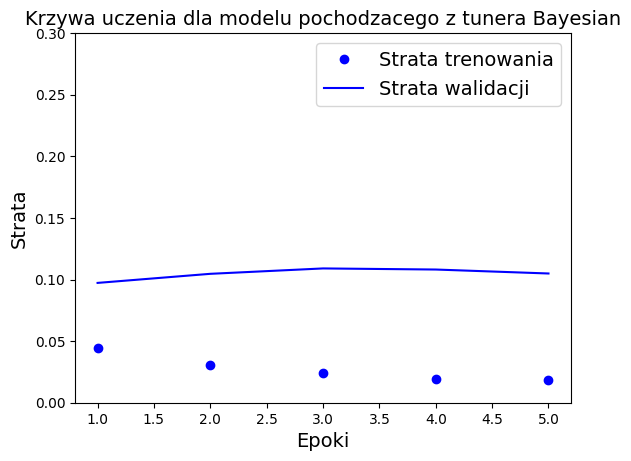

In [51]:
acc = history_bayesian.history['accuracy']
val_acc = history_bayesian.history['val_accuracy']
loss = history_bayesian.history['loss']
val_loss = history_bayesian.history['val_loss']

epochs = range(1, len(acc) + 1)

# Parametr bo definiuje linię przerywaną w postaci niebieskich kropek.
plt.plot(epochs, loss, 'bo', label='Strata trenowania')
# Parametr b definiuje ciągłą niebieską linię.
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
ax = plt.gca()
ax.set_ylim([0, 0.3])
plt.title('Krzywa uczenia dla modelu pochodzacego z tunera Bayesian')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

plt.show()

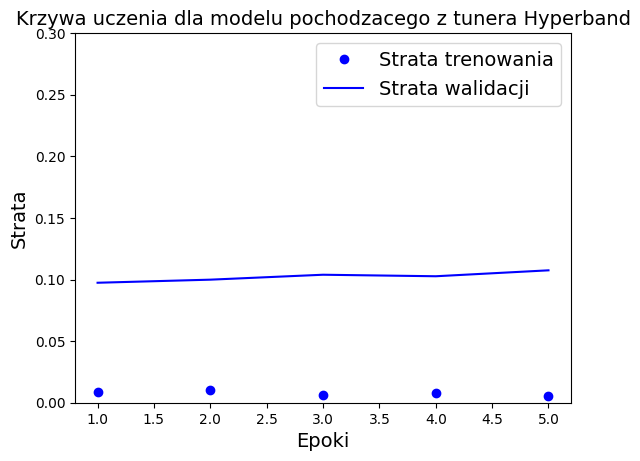

In [52]:
acc = history_hyperband.history['accuracy']
val_acc = history_hyperband.history['val_accuracy']
loss = history_hyperband.history['loss']
val_loss = history_hyperband.history['val_loss']

epochs = range(1, len(acc) + 1)

# Parametr bo definiuje linię przerywaną w postaci niebieskich kropek.
plt.plot(epochs, loss, 'bo', label='Strata trenowania')
# Parametr b definiuje ciągłą niebieską linię.
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
ax = plt.gca()
ax.set_ylim([0, 0.3])
plt.title('Krzywa uczenia dla modelu pochodzacego z tunera Hyperband')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

plt.show()

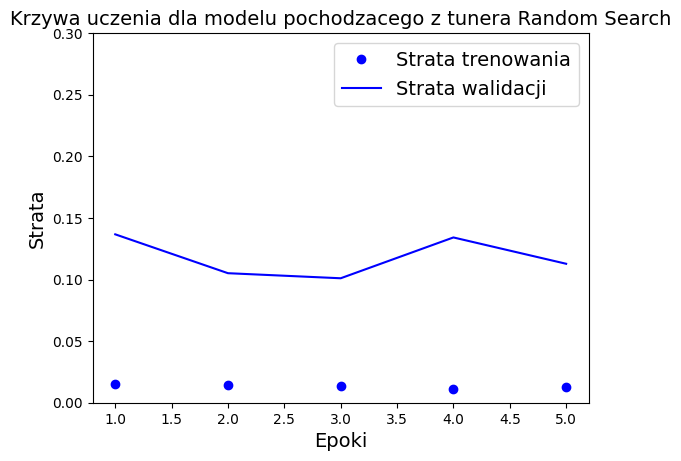

In [53]:
acc = history_random_search.history['accuracy']
val_acc = history_random_search.history['val_accuracy']
loss = history_random_search.history['loss']
val_loss = history_random_search.history['val_loss']

epochs = range(1, len(acc) + 1)

# Parametr bo definiuje linię przerywaną w postaci niebieskich kropek.
plt.plot(epochs, loss, 'bo', label='Strata trenowania')
# Parametr b definiuje ciągłą niebieską linię.
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
ax = plt.gca()
ax.set_ylim([0, 0.3])
plt.title('Krzywa uczenia dla modelu pochodzacego z tunera Random Search')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

plt.show()

In [47]:
test_loss_bayesian, test_accuracy_bayesian = best_model_bayesian.evaluate(X_test, y_test)

test_loss_hyperband, test_accuracy_hyperband = best_model_hyperband.evaluate(X_test, y_test)

test_loss_random_search, test_accuracy_random_search = best_model_random_search.evaluate(X_test, y_test)

print(f"Dokladnosc Bayesian: {test_accuracy_bayesian}\nStrata Bayesian: {test_loss_bayesian}\n")
print(f"Dokladnosc Hyperband: {test_accuracy_hyperband}\nStrata Bayesian: {test_loss_hyperband}\n")
print(f"Dokladnosc Random Search: {test_accuracy_random_search}\nStrata Bayesian: {test_loss_random_search}\n")

313/313 [==============================] - 0s 667us/step - loss: 0.1014 - accuracy: 0.9790
Dokladnosc Bayesian: 0.9764000177383423
Strata Bayesian: 0.09316035360097885

Dokladnosc Hyperband: 0.9801999926567078
Strata Bayesian: 0.07708694785833359

Dokladnosc Random Search: 0.9789999723434448
Strata Bayesian: 0.10139594972133636



In [48]:

if(max(test_accuracy_bayesian,test_accuracy_hyperband,test_accuracy_random_search) == test_accuracy_bayesian):
  test_loss, test_accuracy = best_model_bayesian.evaluate(X_test, y_test)
  print(f"Najlepszy model z tunera Bayesian. Dokladnosc modelu na danych testowych to: {test_accuracy} ze strata rowna {test_loss}")

elif(max(test_accuracy_bayesian,test_accuracy_hyperband,test_accuracy_random_search) == test_accuracy_hyperband):
  test_loss, test_accuracy = best_model_hyperband.evaluate(X_test, y_test)
  print(f"Najlepszy model z tunera Hyperband. Dokladnosc modelu na danych testowych to: {test_accuracy} ze strata rowna {test_loss}")
  
else:
  test_loss, test_accuracy = best_model_random_search.evaluate(X_test, y_test)
  print(f"Najlepszy model z tunera Random Search. Dokladnosc modelu na danych testowych to: {test_accuracy} ze strata rowna {test_loss}")





313/313 [==============================] - 0s 464us/step - loss: 0.0771 - accuracy: 0.9802
Najlepszy model z tunera Hyperband. Dokladnosc modelu na danych testowych to: 0.9801999926567078 ze strata rowna 0.07708694785833359
